In [1]:
import numpy as np
import pandas as pd
from zipfile import ZipFile
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import _pickle as cPickle
import bz2

# Removing scientific notation
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Import data

For compressing and extracting files

In [2]:
def compressed_pickle(title, data):
    with bz2.BZ2File('./data/output/' + title + '.pbz2', 'w') as f:
        cPickle.dump(data, f)
        
def decompress_pickle(file):
    data = bz2.BZ2File(file, 'rb')
    data = cPickle.load(data)
    return data

May take a while to run

In [3]:
hour_trips_dict = decompress_pickle('./data/output/bixi_data_2016_2017_2018.pbz2')
_2019_data = decompress_pickle('./data/output/bixi_data_2019.pbz2')

# Process training data

In [4]:
train_group_data = {}

"""
Blowing Snow', 'Clear', 'Cloudy', 'Drizzle', 'Fog', 'Heavy Rain', 'Ice Pellets', 
                      'Mainly Clear', 'Moderate Rain', 'Moderate Rain Showers', 'Mostly Cloudy', 'Rain',
                      'Rain Showers', 'Snow', 'Snow Showers', 'Thunderstorms', 'Haze', 'Heavy Rain Showers', 
                      'Moderate Drizzle', 'Blowing Dust', 'Freezing Drizzle', 'Freezing Rain', 'Smoke', 
                      'Snow Grains', 'Moderate Snow'
"""
with tqdm(total=len(hour_trips_dict)) as pbar:
    for station_code in hour_trips_dict:
        df = hour_trips_dict[station_code]
        X_train = df[['Temp (°C)', 'Dew Point Temp (°C)', 'Rel Hum (%)', 'Wind Dir (10s deg)',
                      'Wind Spd (km/h)', 'Visibility (km)', 'Stn Press (kPa)', 'Month', 'Hour', 'Day_of_year',
                     'Blowing Snow', 'Clear', 'Cloudy', 'Drizzle', 'Fog', 'Heavy Rain', 'Ice Pellets', 
                      'Mainly Clear', 'Moderate Rain', 'Moderate Rain Showers', 'Mostly Cloudy', 'Rain',
                      'Rain Showers', 'Snow', 'Snow Showers', 'Thunderstorms', 'Haze', 'Heavy Rain Showers', 
                      'Moderate Drizzle', 'Blowing Dust', 'Freezing Drizzle', 'Freezing Rain', 'Smoke', 
                      'Snow Grains', 'Moderate Snow']]
        y_train = df[['hour_trip_count']]

        train_group_data[station_code] = {
            "X_train": X_train,
            "y_train": y_train
        }
        pbar.update(1)

100%|██████████| 463/463 [00:03<00:00, 138.12it/s]


# Process test and validation data

In [5]:
from sklearn.model_selection import train_test_split

test_validation_group_data = {}

with tqdm(total=len(_2019_data)) as pbar:
    for station_code in _2019_data:
        df = _2019_data[station_code]
        
        X_tv = df[['Temp (°C)', 'Dew Point Temp (°C)', 'Rel Hum (%)', 'Wind Dir (10s deg)',
                      'Wind Spd (km/h)', 'Visibility (km)', 'Stn Press (kPa)', 'Month', 'Hour', 'Day_of_year',
                     'Blowing Snow', 'Clear', 'Cloudy', 'Drizzle', 'Fog', 'Heavy Rain', 'Ice Pellets', 
                      'Mainly Clear', 'Moderate Rain', 'Moderate Rain Showers', 'Mostly Cloudy', 'Rain',
                      'Rain Showers', 'Snow', 'Snow Showers', 'Thunderstorms', 'Haze', 'Heavy Rain Showers', 
                      'Moderate Drizzle', 'Blowing Dust', 'Freezing Drizzle', 'Freezing Rain', 'Smoke', 
                      'Snow Grains', 'Moderate Snow']]
        y_tv = df[['hour_trip_count']]

        X_test, X_val, y_test, y_val = train_test_split(X_tv, y_tv, test_size=0.5, random_state=0)
        
        test_validation_group_data[station_code] = {
            "X_test": X_test,
            "y_test": y_test,
            "X_val": X_val,
            "y_val": y_val
        }
        pbar.update(1)

100%|██████████| 463/463 [00:02<00:00, 176.14it/s]


# Training models

In [6]:
from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Ridge Regression

In [7]:
models_ridge = {} # Keeps track of the trained model
models_ridge_train_acc = {} # Accuracy on training data
models_ridge_test_acc = {} # Accuracy on test data
models_ridge_val_acc = {} # Accuracy on validation data

with tqdm(total=len(train_group_data)) as pbar:
    for key in train_group_data:
        # Data
        X_train = train_group_data[key]['X_train'].copy()
        y_train = train_group_data[key]['y_train']
        
        X_test = test_validation_group_data[key]['X_test'].copy()
        y_test = test_validation_group_data[key]['y_test']
        
        X_val = test_validation_group_data[key]['X_val'].copy()
        y_val = test_validation_group_data[key]['y_val']
        
        # Model
        model = Ridge(alpha=1).fit(X_train, y_train)
        models_ridge[key] = model
        
        # Training error
        pred = model.predict(X_train)
        models_ridge_train_acc[key] = mean_absolute_error(y_train, pred)
        
        # Validation error
        pred = model.predict(X_val)
        models_ridge_val_acc[key] = mean_absolute_error(y_val, pred)

        # Testing error
        pred = model.predict(X_test)
        models_ridge_test_acc[key] = mean_absolute_error(y_test, pred)
        
        pbar.update(1)

100%|██████████| 463/463 [00:09<00:00, 48.09it/s]


In [9]:
pd.DataFrame.from_dict(models_ridge_train_acc, orient='index', columns=['Train MAE']).describe()

,Train MAE
count,463.000
mean,1.505
std,0.828
min,0.123
25%,0.879
50%,1.336
75%,1.921
max,5.651


In [10]:
pd.DataFrame.from_dict(models_ridge_test_acc, orient='index', columns=['Test MAE']).describe()

,Test MAE
count,463.000
mean,1.667
std,0.923
min,0.158
25%,0.986
50%,1.491
75%,2.113
max,5.874


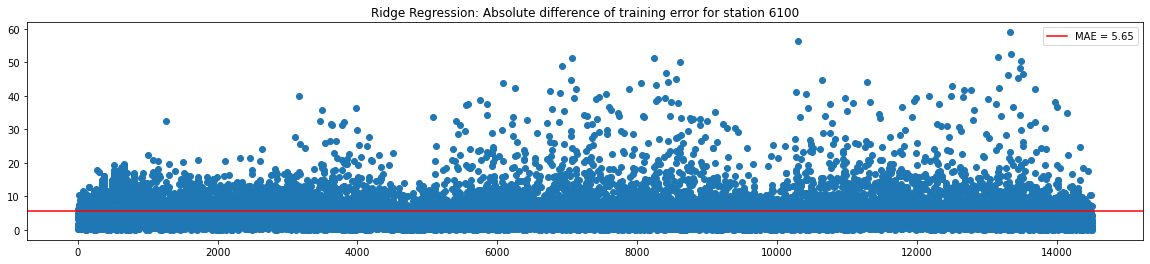

In [87]:
target_station = 6100

y_train_pred = models_ridge[target_station].predict(train_group_data[target_station]['X_train'].copy())
y_train_true = train_group_data[target_station]['y_train']
x = np.arange(len(y_train_true))

mean = models_ridge_train_acc[6100]

diff = np.abs(np.subtract(y_train_pred, y_train_true))

plt.figure(figsize=(20,4))
plt.title("Ridge Regression: Absolute difference of training error for station 6100")
plt.axhline(y=mean, color='r', linestyle='-', label="MAE = %.2f" % mean)
plt.scatter(x, diff)
plt.legend()
plt.show()

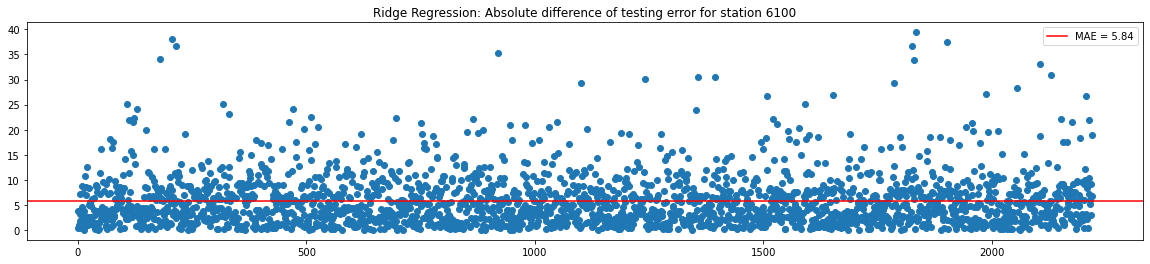

In [93]:
target_station = 6100

y_test_pred = models_ridge[target_station].predict(test_validation_group_data[target_station]['X_test'].copy())
y_test_true = test_validation_group_data[target_station]['y_test']
x = np.arange(len(y_test_true))

mean = models_ridge_test_acc[6100]

diff = np.abs(np.subtract(y_test_pred, y_test_true))

plt.figure(figsize=(20,4))
plt.title("Ridge Regression: Absolute difference of testing error for station 6100")
plt.axhline(y=mean, color='r', linestyle='-', label="MAE = %.2f" % mean)
plt.scatter(x, diff)
plt.legend()
plt.show()

# k-NN regression

Finding the best k

In [73]:
models_knnr = {} # Keeps track of the trained model
models_knnr_train_acc = {} # Accuracy on training data
models_knnr_test_acc = {} # Accuracy on test data
models_knnr_val_acc = {} # Accuracy on validation data

n = [2,4,8,16,32,64,128]

with tqdm(total=len(train_group_data)) as pbar:
    for key in train_group_data:
        # Data
        X_train = train_group_data[key]['X_train'].copy()
        y_train = train_group_data[key]['y_train']
        
        
        X_test = test_validation_group_data[key]['X_test'].copy()
        y_test = test_validation_group_data[key]['y_test']
        
        X_val = test_validation_group_data[key]['X_val'].copy()
        y_val = test_validation_group_data[key]['y_val']
        
        models_knnr_train_acc[key] = []
        models_knnr_test_acc[key] = []
        models_knnr_val_acc[key] = []

        for i in n:
            # Model
            model = KNeighborsRegressor(n_neighbors=i).fit(X_train, y_train)
            models_knnr[key] = model

            # Training error
            pred = model.predict(X_train)
            models_knnr_train_acc[key].append(mean_absolute_error(y_train, pred))

            # Validation error
            pred = model.predict(X_val)
            models_knnr_val_acc[key].append(mean_absolute_error(y_val, pred))

            # Testing error
            pred = model.predict(X_test)
            models_knnr_test_acc[key].append(mean_absolute_error(y_test, pred))
        
        pbar.update(1)

100%|██████████| 463/463 [1:07:37<00:00,  8.76s/it]  


In [75]:
pd.DataFrame(models_knnr_val_acc).T.rename({0:2, 1:4, 2:8, 3:16, 4:32, 5:64, 6:128}, axis=1).describe()

,2,4,8,16,32,64,128
count,463.000,463.000,463.000,463.000,463.000,463.000,463.000
mean,1.855,1.748,1.687,1.659,1.651,1.661,1.678
std,1.005,0.943,0.908,0.891,0.887,0.895,0.911
min,0.158,0.155,0.158,0.159,0.159,0.161,0.162
25%,1.079,1.026,1.000,0.991,0.991,0.994,1.002
50%,1.661,1.568,1.509,1.490,1.486,1.497,1.522
75%,2.355,2.210,2.123,2.101,2.100,2.098,2.123
max,6.482,5.983,5.879,5.794,5.742,5.757,5.828


Best one is 32

In [78]:
pd.DataFrame(models_knnr_test_acc).T.rename({0:2, 1:4, 2:8, 3:16, 4:32, 5:64, 6:128}, axis=1)[[32]].describe().rename({32: "Train MAE"}, axis=1)


,Train MAE
count,463.000
mean,1.650
std,0.889
min,0.158
25%,0.978
50%,1.501
75%,2.108
max,5.673


Training the model with k=32

In [69]:
models_best_knnr = {} # Keeps track of the trained model
models_best_knnr_train_acc = {} # Accuracy on training data
models_best_knnr_test_acc = {} # Accuracy on test data
models_best_knnr_val_acc = {} # Accuracy on validation data

with tqdm(total=len(train_group_data)) as pbar:
    for key in train_group_data:
        # Data
        X_train = train_group_data[key]['X_train'].copy()
        y_train = train_group_data[key]['y_train']
        
        
        X_test = test_validation_group_data[key]['X_test'].copy()
        y_test = test_validation_group_data[key]['y_test']
        
        X_val = test_validation_group_data[key]['X_val'].copy()
        y_val = test_validation_group_data[key]['y_val']

        # Model
        model = KNeighborsRegressor(n_neighbors=32).fit(X_train, y_train)
        models_best_knnr[key] = model

        # Training error
        pred = model.predict(X_train)
        models_best_knnr_train_acc[key] = mean_absolute_error(y_train, pred)

        # Validation error
        pred = model.predict(X_val)
        models_best_knnr_val_acc[key] = mean_absolute_error(y_val, pred)

        # Testing error
        pred = model.predict(X_test)
        models_best_knnr_test_acc[key] = mean_absolute_error(y_test, pred)
        
        pbar.update(1)

100%|██████████| 463/463 [09:57<00:00,  1.29s/it]


In [70]:
pd.DataFrame.from_dict(models_best_knnr_train_acc, orient='index', columns=['Train MAE']).describe()

,Train MAE
count,463.000
mean,1.393
std,0.728
min,0.120
25%,0.835
50%,1.250
75%,1.775
max,4.965


In [71]:
pd.DataFrame.from_dict(models_best_knnr_test_acc , orient='index', columns=['Test MAE']).describe()

,Test MAE
count,463.000
mean,1.650
std,0.889
min,0.158
25%,0.978
50%,1.501
75%,2.108
max,5.673


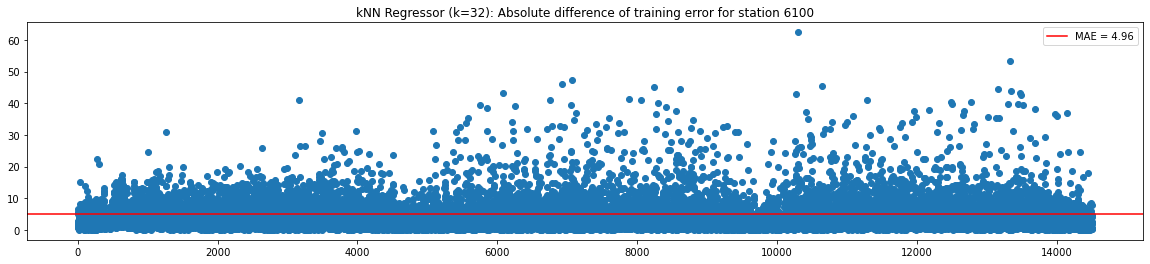

In [94]:
target_station = 6100

y_train_pred = models_best_knnr[target_station].predict(train_group_data[target_station]['X_train'].copy())
y_train_true = train_group_data[target_station]['y_train']
x = np.arange(len(y_train_true))

mean = models_best_knnr_train_acc[target_station]

diff = np.abs(np.subtract(y_train_pred, y_train_true))

plt.figure(figsize=(20,4))
plt.title("kNN Regressor (k=32): Absolute difference of training error for station 6100")
plt.axhline(y=mean, color='r', linestyle='-', label="MAE = %.2f" % mean)
plt.scatter(x, diff)
plt.legend()
plt.show()

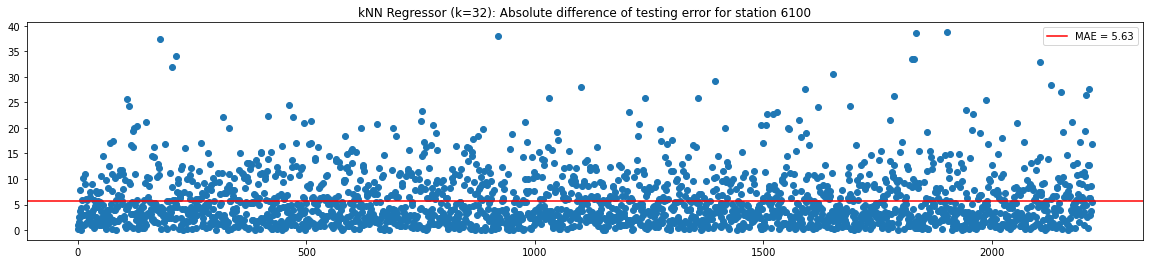

In [95]:
target_station = 6100

y_test_pred = models_best_knnr[target_station].predict(test_validation_group_data[target_station]['X_test'].copy())
y_test_true = test_validation_group_data[target_station]['y_test']
x = np.arange(len(y_test_true))

mean = models_best_knnr_test_acc[target_station]

diff = np.abs(np.subtract(y_test_pred, y_test_true))

plt.figure(figsize=(20,4))
plt.title("kNN Regressor (k=32): Absolute difference of testing error for station 6100")
plt.axhline(y=mean, color='r', linestyle='-', label="MAE = %.2f" % mean)
plt.scatter(x, diff)
plt.legend()
plt.show()

# Decision Tree Regression

Finding the best maximum depth 

In [26]:
models_dtr = {} # Keeps track of the trained model
models_dtr_train_acc = {} # Accuracy on training data
models_dtr_test_acc = {} # Accuracy on test data
models_dtr_val_acc = {} # Accuracy on validation data

md = [2,4,8,16,32,64,128]

with tqdm(total=len(train_group_data)) as pbar:
    for key in train_group_data:
        # Data
        X_train = train_group_data[key]['X_train'].copy()
        y_train = train_group_data[key]['y_train']
        
        X_test = test_validation_group_data[key]['X_test'].copy()
        y_test = test_validation_group_data[key]['y_test']
        
        X_val = test_validation_group_data[key]['X_val'].copy()
        y_val = test_validation_group_data[key]['y_val']
        
        models_dtr[key] = []
        models_dtr_train_acc[key] = []
        models_dtr_test_acc[key] = []
        models_dtr_val_acc[key] = []
        
        for i in md:
            # Model
            model = DecisionTreeRegressor(max_depth=i).fit(X_train, y_train)
            models_dtr[key].append(model)

            # Training error
            pred = model.predict(X_train)
            models_dtr_train_acc[key].append(mean_absolute_error(y_train, pred))

            # Validation error
            pred = model.predict(X_val)
            models_dtr_val_acc[key].append(mean_absolute_error(y_val, pred))

            # Testing error
            pred = model.predict(X_test)
            models_dtr_test_acc[key].append(mean_absolute_error(y_test, pred))
        
        pbar.update(1)

100%|██████████| 463/463 [04:02<00:00,  1.91it/s]


In [34]:
pd.DataFrame(models_dtr_train_acc).T.rename({0:2, 1:4, 2:8, 3:16, 4:32, 5:64, 6:128}, axis=1).describe()


,2,4,8,16,32,64,128
count,463.000,463.000,463.000,463.000,463.000,463.000,463.000
mean,1.447,1.333,1.187,0.517,0.004,0.000,0.000
std,0.794,0.699,0.593,0.243,0.007,0.000,0.000
min,0.122,0.120,0.110,0.044,0.000,0.000,0.000
25%,0.834,0.790,0.718,0.342,0.000,0.000,0.000
50%,1.280,1.193,1.072,0.477,0.001,0.000,0.000
75%,1.879,1.708,1.528,0.649,0.004,0.000,0.000
max,5.455,4.941,4.065,1.590,0.065,0.000,0.000


Max depth of 8 seems to be the best

In [36]:
# Selecting the model with max depth 8
pd.DataFrame(models_dtr_train_acc).T.rename({0:2, 1:4, 2:8, 3:16, 4:32, 5:64, 6:128}, axis=1)[[8]].describe().rename({8: "Train MAE"}, axis=1)


,Train MAE
count,463.000
mean,1.187
std,0.593
min,0.110
25%,0.718
50%,1.072
75%,1.528
max,4.065


In [37]:
pd.DataFrame(models_dtr_test_acc).T.rename({0:2, 1:4, 2:8, 3:16, 4:32, 5:64, 6:128}, axis=1)[[8]].describe().rename({8: "Test MAE"}, axis=1)


,Test MAE
count,463.000
mean,1.490
std,0.781
min,0.156
25%,0.903
50%,1.360
75%,1.884
max,5.207


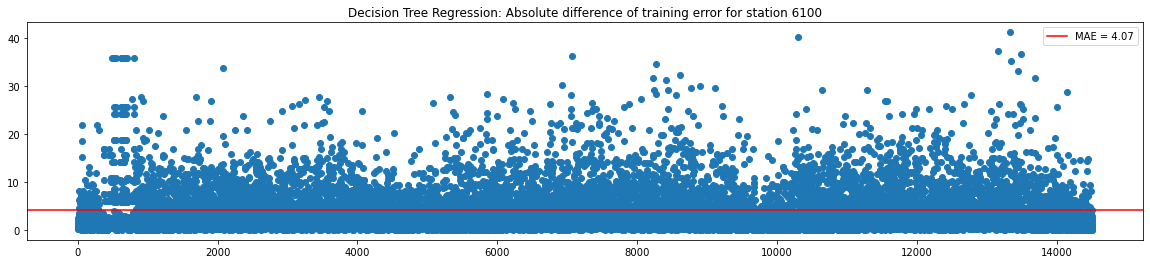

In [96]:
target_station = 6100

y_train_pred = models_dtr[target_station][2].predict(train_group_data[target_station]['X_train'].copy())
y_train_true = train_group_data[target_station]['y_train'].to_numpy().flatten()
x = np.arange(len(y_train_true))

mean = models_dtr_train_acc[target_station][2]

diff = np.abs(np.subtract(y_train_pred, y_train_true))

plt.figure(figsize=(20,4))
plt.title("Decision Tree Regression: Absolute difference of training error for station 6100")
plt.axhline(y=mean, color='r', linestyle='-', label="MAE = %.2f" % mean)
plt.scatter(x, diff)
plt.legend()
plt.show()

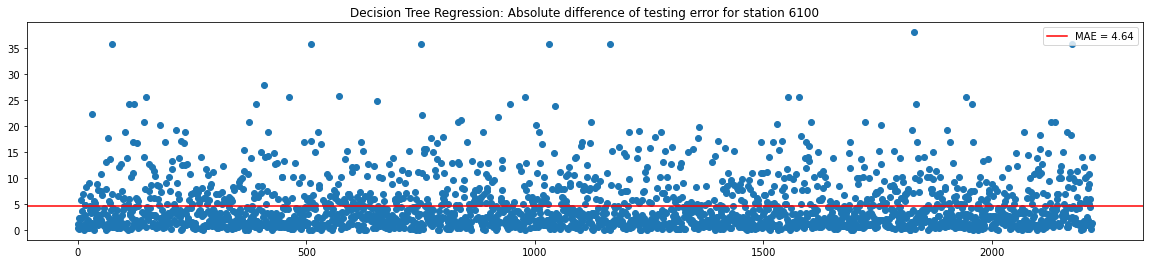

In [97]:
target_station = 6100

y_test_pred = models_dtr[target_station][2].predict(test_validation_group_data[target_station]['X_test'].copy())
y_test_true = test_validation_group_data[target_station]['y_test'].to_numpy().flatten()
x = np.arange(len(y_test_true))

mean = models_dtr_test_acc[target_station][2]

diff = np.abs(np.subtract(y_test_pred, y_test_true))

plt.figure(figsize=(20,4))
plt.title("Decision Tree Regression: Absolute difference of testing error for station 6100")
plt.axhline(y=mean, color='r', linestyle='-', label="MAE = %.2f" % mean)
plt.scatter(x, diff)
plt.legend()
plt.show()